The LetoHealth app aids healthcare professionals specializing in infertility aid patients undergoing the IVF process to select the best embryo for lab transfer.

Loading Required Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

# Reading the data

In [2]:
levels = ['1', '2', '3', '4', '5']
path = "embryo-dataset/ed4/alldata"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'embryo_dataset'])

data['path'] = path + '/' + data['image_file']
data['embryo_dataset'] = data['embryo_dataset'].map({'1': 'Degenerate','2': 'Morula','3':'Early Blastocyst', '4': 'Full Blastocyst','5': 'Hatched Blastocyst'})

samples = 2440

data.head(2400)


image_file      embryo_dataset                                  path
0       1/0.png          Degenerate    embryo-dataset/ed4/alldata/1/0.png
1       1/1.png          Degenerate    embryo-dataset/ed4/alldata/1/1.png
2      1/10.png          Degenerate   embryo-dataset/ed4/alldata/1/10.png
3     1/100.png          Degenerate  embryo-dataset/ed4/alldata/1/100.png
4     1/101.png          Degenerate  embryo-dataset/ed4/alldata/1/101.png
...         ...                 ...                                   ...
2395  5/703.png  Hatched Blastocyst  embryo-dataset/ed4/alldata/5/703.png
2396  5/704.png  Hatched Blastocyst  embryo-dataset/ed4/alldata/5/704.png
2397  5/705.png  Hatched Blastocyst  embryo-dataset/ed4/alldata/5/705.png
2398  5/706.png  Hatched Blastocyst  embryo-dataset/ed4/alldata/5/706.png
2399  5/707.png  Hatched Blastocyst  embryo-dataset/ed4/alldata/5/707.png

[2400 rows x 3 columns]

In [3]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 2440


In [4]:
df = pd.DataFrame()
df['embryo_dataset'] = ['Degenerate', 'Morula', 'Early Blastocyst', 'Full Blastocyst', 'Hatched Blastocyst']
df['Count'] = [len(data[data['embryo_dataset'] == 'Degenerate']), len(data[data['embryo_dataset'] == 'Morula']),len(data[data['embryo_dataset'] == 'Early Blastocyst']), len(data[data['embryo_dataset'] == 'Full Blastocyst']),len(data[data['embryo_dataset'] == 'Hatched Blastocyst'])]

df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'embryo_dataset', y = 'Count', 
             color = "embryo_dataset", text_auto='', width = 800, 
             color_discrete_sequence = ["green", "red", "yellow", "orange", "blue"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [6]:
IMAGE_SIZE= 75
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))

data.head()

image_file embryo_dataset                                  path  \
0    1/0.png     Degenerate    embryo-dataset/ed4/alldata/1/0.png   
1    1/1.png     Degenerate    embryo-dataset/ed4/alldata/1/1.png   
2   1/10.png     Degenerate   embryo-dataset/ed4/alldata/1/10.png   
3  1/100.png     Degenerate  embryo-dataset/ed4/alldata/1/100.png   
4  1/101.png     Degenerate  embryo-dataset/ed4/alldata/1/101.png   

                                               image  
0  [[[53, 53, 53], [60, 60, 60], [52, 52, 52], [4...  
1  [[[72, 72, 72], [78, 78, 78], [70, 70, 70], [7...  
2  [[[56, 56, 56], [43, 43, 43], [34, 34, 34], [5...  
3  [[[59, 59, 59], [40, 40, 40], [45, 45, 45], [6...  
4  [[[63, 63, 63], [67, 67, 67], [81, 81, 81], [6...

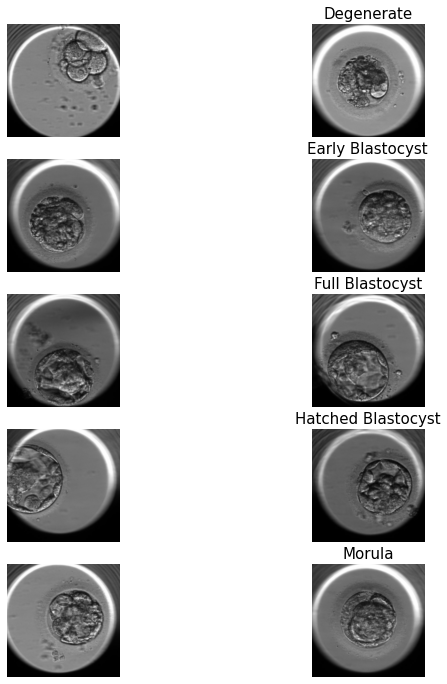

In [18]:
n_samples = 2

fig, m_axs = plt.subplots(5, n_samples, figsize = (5*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['embryo_dataset']).groupby('embryo_dataset')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

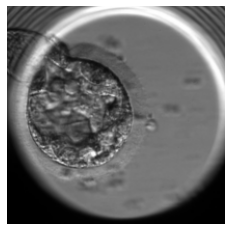

In [19]:
plt.figure()
image = cv2.imread("embryo-dataset/ed4/alldata/4/100.png")
plt.imshow(image)
plt.axis('off')
plt.show()

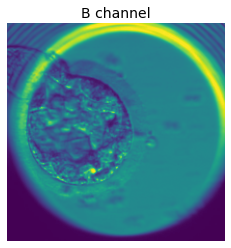

In [20]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

In [21]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

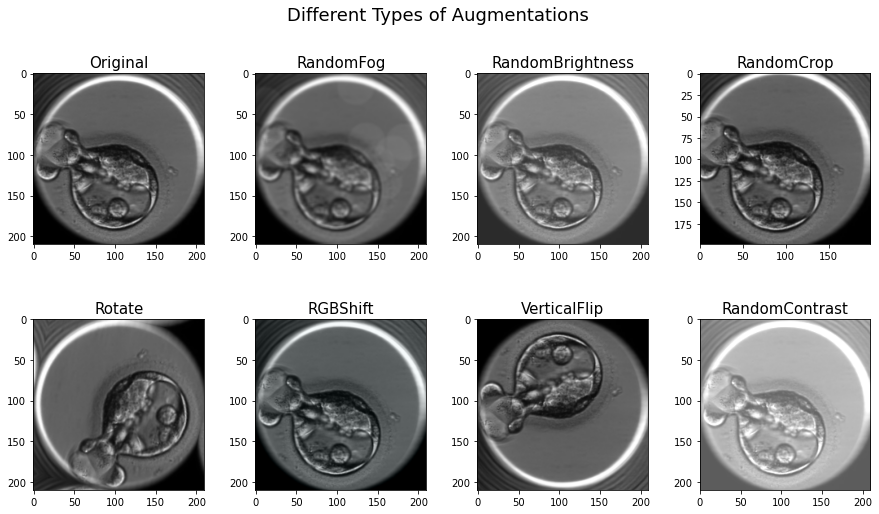

In [22]:
chosen_image = cv2.imread("embryo-dataset/ed4/alldata/5/592.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightnessContrast(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomBrightnessContrast(brightness_limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

In [23]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','embryo_dataset','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

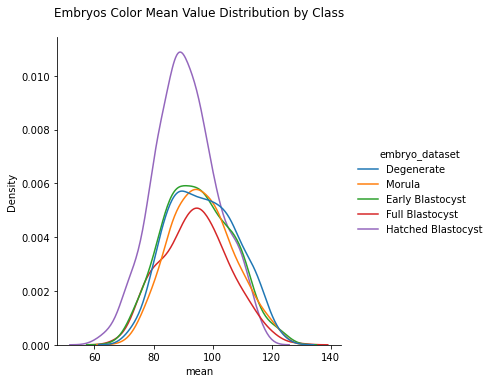

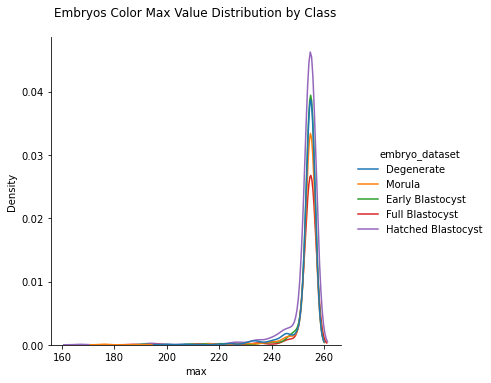

C:\Users\sbhum\AppData\Local\Temp\ipykernel_20080\131305359.py:13: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



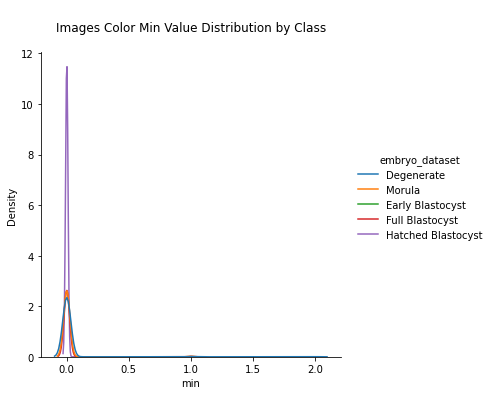

In [24]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'embryo_dataset');
plt.title('Embryos Color Mean Value Distribution by Class\n', fontsize = 12);
plt.savefig('Embryo-mean-value-distribution-by-class.png')
plt.show()


ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'embryo_dataset');
plt.title('Embryos Color Max Value Distribution by Class\n', fontsize = 12);
plt.savefig('Embryo-max-value-distribution-by-class.png')
plt.show()


ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'embryo_dataset');
plt.title('\nImages Color Min Value Distribution by Class\n', fontsize = 12);
plt.show()

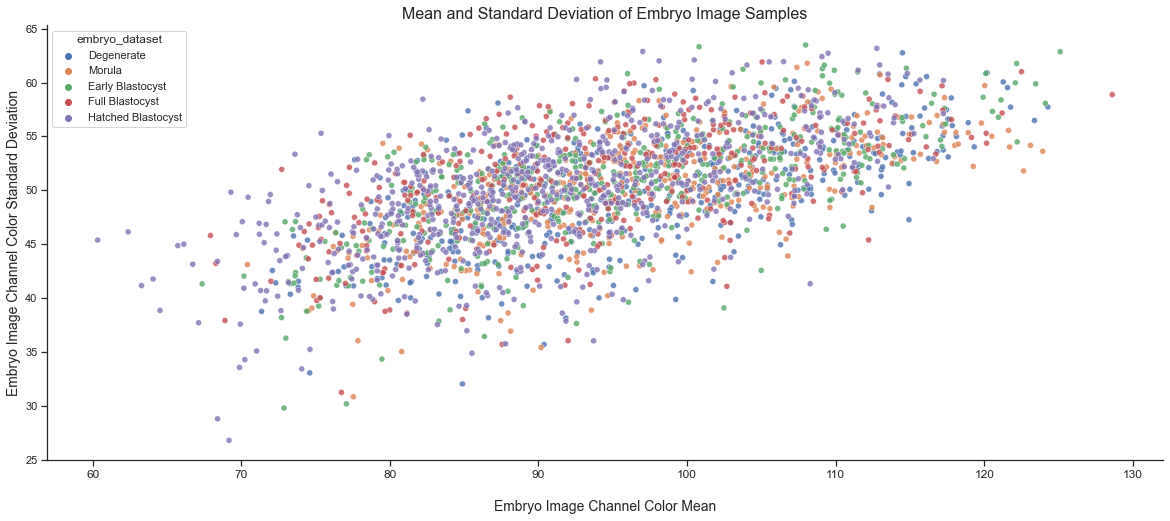

In [25]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'embryo_dataset', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nEmbryo Image Channel Color Mean', fontsize = 14)
ax.set_ylabel('Embryo Image Channel Color Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Embryo Image Samples', fontsize = 16);

<Figure size 720x576 with 0 Axes>

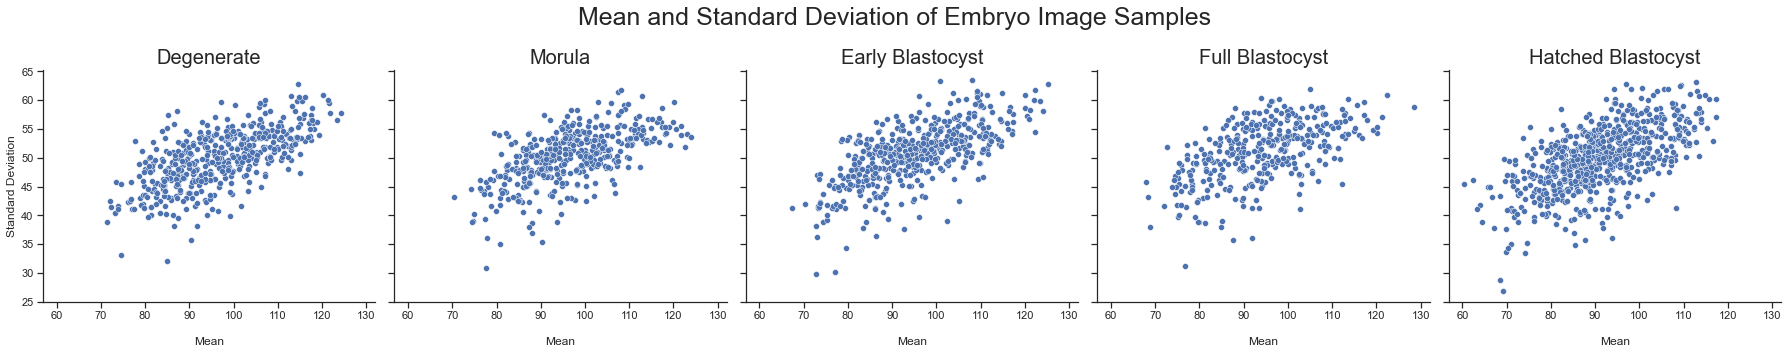

In [26]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "embryo_dataset", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 20);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Embryo Image Samples', fontsize = 25);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

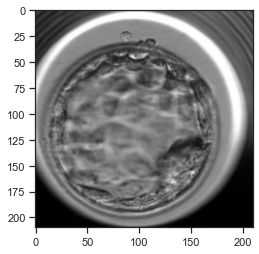

In [27]:
image = cv2.imread(data['path'][2000])
plt.imshow(image)

In [28]:
#random.shuffle(data['path'])

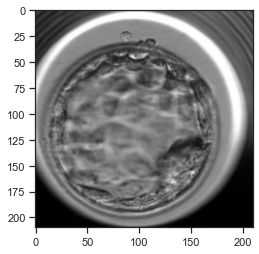

In [29]:
image = cv2.imread(data['path'][2000])
plt.imshow(image)

# Data Modeling

In [4]:
IMAGE_SIZE = 256
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    if data['embryo_dataset'][i] == 'Degenerate':
        label = 1
    elif data['embryo_dataset'][i] == 'Morula':
        label = 2
    elif data['embryo_dataset'][i] == 'Early Blastocyst':
        label = 3
    elif data['embryo_dataset'][i] == 'Full Blastocyst':
        label = 4
    elif data['embryo_dataset'][i] == 'Hatched Blastocyst':
        label = 5
    all_data.append([image, label])

In [5]:
data['embryo_dataset'][0]

'Degenerate'

In [6]:
label

5

In [7]:
random.shuffle(all_data)

In [9]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

val_split = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify=y, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_split, random_state = 42)

x = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1647, 256, 256, 3) (610, 256, 256, 3) (183, 256, 256, 3) (1647,) (610,) (183,)


In [10]:
y

array([3, 2, 1, ..., 5, 1, 2])

In [11]:
y_train[4]

4

# Encode the labels using LabelBinarizer

In [12]:
from sklearn.preprocessing import LabelBinarizer

lb=LabelBinarizer()

y_train=lb.fit_transform(y_train)
y_val=lb.fit_transform(y_val)
y_test=lb.fit_transform(y_test)

In [13]:
y_train[4]

array([0, 0, 0, 1, 0])

In [14]:
y_val[1]

array([0, 0, 0, 0, 1])

In [15]:
y_test[4]

array([0, 0, 0, 0, 1])

In [16]:
#training split
len(x_train)

1647

In [17]:
#testing split
len(x_test)

610

In [18]:
# valuation split
len(x_val)

183

# CNN Model

In [19]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Dropout(0.5))

#Flatten
cnn_model.add(layers.Flatten())

#Dense Layer
cnn_model.add(layers.Dense(units=512,activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(units=256,activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(units=128,activation='relu'))
cnn_model.add(layers.Dropout(0.2))

#output layer
cnn_model.add(layers.Dense(units = 5,activation='softmax'))

In [26]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 5, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 128)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

In [20]:
print(len(cnn_model.layers))

16


In [21]:
from tensorflow.keras.optimizers import Nadam
opt = Nadam(learning_rate=1e-4, decay=1e-4)
cnn_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# data augmentation

In [22]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=True,
                                   rotation_range=20,
                                   shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Make sure you provide the same target size as initialied for the image size
BATCH_SIZE = 64
IMAGE_SIZE = 256
training_set = train_datagen.flow_from_directory('embryo-dataset/ed4/alldata',
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 2440 images belonging to 5 classes.


In [24]:
test_set = test_datagen.flow_from_directory('embryo-dataset/ed4/alldata',
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 2440 images belonging to 5 classes.


(64, 256, 256, 3)


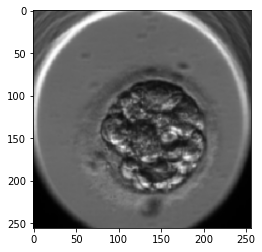

(64, 256, 256, 3)


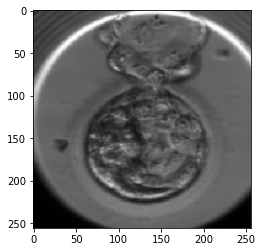

(64, 256, 256, 3)


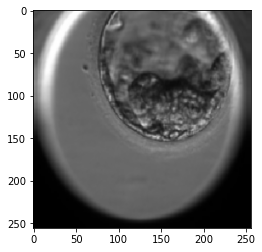

(64, 256, 256, 3)


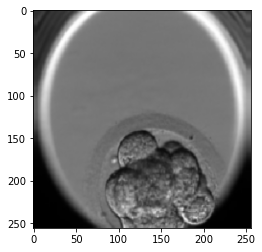

(64, 256, 256, 3)


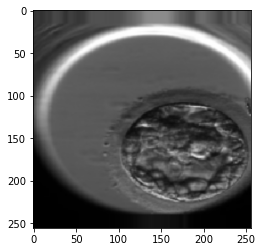

In [25]:
for _ in range(5):
    img, label = training_set.next()
    print(img.shape)   #  (32, 128, 128, 3)
    plt.imshow(img[0])
    plt.show()

In [26]:
history = cnn_model.fit(
  training_set,
  validation_data=test_set,
  epochs=150,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/150
39/39 [==============================] - 504s 13s/step - loss: 1.7263 - accuracy: 0.2234 - val_loss: 1.5980 - val_accuracy: 0.2951
Epoch 2/150
39/39 [==============================] - 379s 10s/step - loss: 1.6051 - accuracy: 0.2586 - val_loss: 1.6004 - val_accuracy: 0.2939
Epoch 3/150
39/39 [==============================] - 289s 7s/step - loss: 1.5990 - accuracy: 0.2832 - val_loss: 1.5997 - val_accuracy: 0.2939
Epoch 4/150
39/39 [==============================] - 281s 7s/step - loss: 1.5932 - accuracy: 0.2881 - val_loss: 1.5969 - val_accuracy: 0.2939
Epoch 5/150
39/39 [==============================] - 259s 7s/step - loss: 1.5839 - accuracy: 0.2963 - val_loss: 1.5954 - val_accuracy: 0.2939
Epoch 6/150
39/39 [==============================] - 300s 8s/step - loss: 1.5813 - accuracy: 0.2930 - val_loss: 1.5919 - val_accuracy: 0.2943
Epoch 7/150
39/39 [==============================] - 254s 7s/step - loss: 1.5797 - accuracy: 0.2926 - val_loss: 1.5896 - val_accuracy: 0.2939
Epoc

39/39 [==============================] - 176s 4s/step - loss: 1.4195 - accuracy: 0.3652 - val_loss: 1.5431 - val_accuracy: 0.2832
Epoch 59/150
39/39 [==============================] - 191s 5s/step - loss: 1.4267 - accuracy: 0.3676 - val_loss: 1.5589 - val_accuracy: 0.2660
Epoch 60/150
39/39 [==============================] - 192s 5s/step - loss: 1.4261 - accuracy: 0.3639 - val_loss: 1.5486 - val_accuracy: 0.2844
Epoch 61/150
39/39 [==============================] - 189s 5s/step - loss: 1.4145 - accuracy: 0.3631 - val_loss: 1.5365 - val_accuracy: 0.2902
Epoch 62/150
39/39 [==============================] - 185s 5s/step - loss: 1.4104 - accuracy: 0.3684 - val_loss: 1.5512 - val_accuracy: 0.2799
Epoch 63/150
39/39 [==============================] - 184s 5s/step - loss: 1.4148 - accuracy: 0.3672 - val_loss: 1.5637 - val_accuracy: 0.2672
Epoch 64/150
39/39 [==============================] - 196s 5s/step - loss: 1.4154 - accuracy: 0.3656 - val_loss: 1.5330 - val_accuracy: 0.2893
Epoch 65/150

39/39 [==============================] - 154s 4s/step - loss: 1.3267 - accuracy: 0.4082 - val_loss: 1.4922 - val_accuracy: 0.3225
Epoch 116/150
39/39 [==============================] - 158s 4s/step - loss: 1.3391 - accuracy: 0.4037 - val_loss: 1.5240 - val_accuracy: 0.3102
Epoch 117/150
39/39 [==============================] - 163s 4s/step - loss: 1.3199 - accuracy: 0.4168 - val_loss: 1.4944 - val_accuracy: 0.3238
Epoch 118/150
39/39 [==============================] - 164s 4s/step - loss: 1.3340 - accuracy: 0.4016 - val_loss: 1.4799 - val_accuracy: 0.3307
Epoch 119/150
39/39 [==============================] - 157s 4s/step - loss: 1.3021 - accuracy: 0.4221 - val_loss: 1.4713 - val_accuracy: 0.3344
Epoch 120/150
39/39 [==============================] - 166s 4s/step - loss: 1.3224 - accuracy: 0.4119 - val_loss: 1.4661 - val_accuracy: 0.3414
Epoch 121/150
39/39 [==============================] - 168s 4s/step - loss: 1.3228 - accuracy: 0.4139 - val_loss: 1.4883 - val_accuracy: 0.3266
Epoch 

# Save Model

In [10]:
# h5 is a serialization format
cnn_model.save('day5_embryo_cnn_model.h5')

NameError: name 'cnn_model' is not defined

In [42]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

20/20 [==============================] - 3s 138ms/step


# Reports

In [11]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Day 5 Embryos CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
plt.savefig('Results/CNN-Embryo-Accuracy-Comparison.png')

NameError: name 'history' is not defined

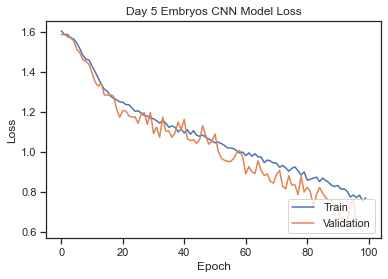

<Figure size 432x288 with 0 Axes>

In [44]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Day 5 Embryos CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()
#plt.savefig('Results/CNN-Embryo-Loss-Comparison.png')

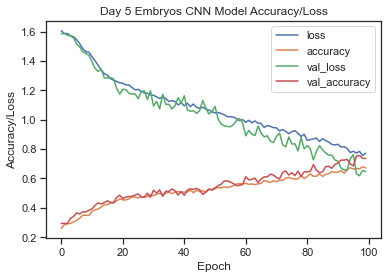

<Figure size 432x288 with 0 Axes>

In [47]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Day 5 Embryos CNN Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('Results/CNN-Embryo-Accuracy-Loss-Comparison.png')

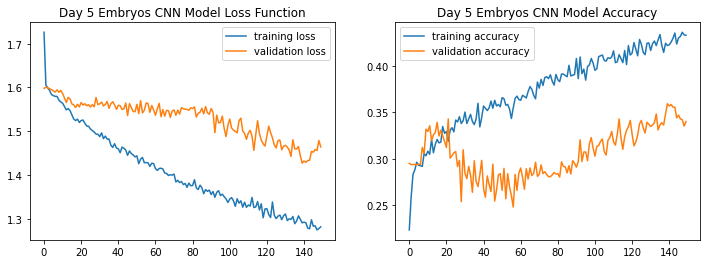

In [27]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Day 5 Embryos CNN Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Day 5 Embryos CNN Model Accuracy')
#plt.savefig('Results/Day-5 Embryos-CNN-Model-Accuracy-Loss.png')
plt.legend();

# Predicting Test Dataset

20/20 [==============================] - 3s 132ms/step


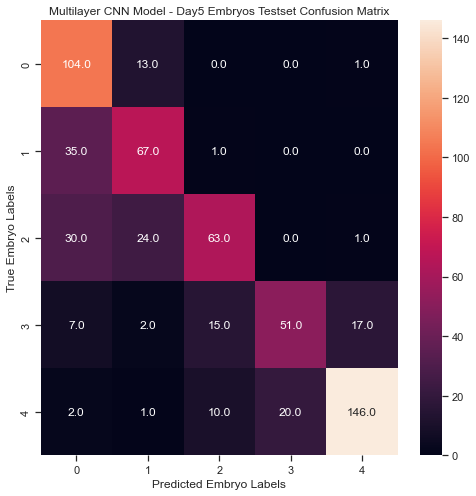

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = cnn_model.predict(x_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# https://www.v7labs.com/blog/confusion-matrix-guide

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Embryo Labels')
plt.ylabel('True Embryo Labels')
plt.title('Multilayer CNN Model - Day5 Embryos Testset Confusion Matrix')
plt.savefig('Results/Day5-Embryos-MultilayerCNN-Model-Confusion-Matrix.png')
plt.show();

In [51]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70       118
           1       0.63      0.65      0.64       103
           2       0.71      0.53      0.61       118
           3       0.72      0.55      0.63        92
           4       0.88      0.82      0.85       179

    accuracy                           0.71       610
   macro avg       0.70      0.69      0.68       610
weighted avg       0.72      0.71      0.70       610



In [52]:
y_train_arg=np.argmax(y_train,axis=1)
yp_train = np.argmax(cnn_model.predict(x_train),axis=1)
print('Train Confusion Matrix')
print(confusion_matrix(y_train_arg, yp_train))

52/52 [==============================] - 8s 143ms/step
Train Confusion Matrix
[[281  42   2   0   0]
 [103 167   5   0   0]
 [ 72  81 160   2   0]
 [ 11  12  53 135  35]
 [  7   4  27  36 412]]


In [53]:
y_val_arg=np.argmax(y_val,axis=1)
yp_val = np.argmax(cnn_model.predict(x_val),axis=1)
print('Val Confusion Matrix')
print(confusion_matrix(y_val_arg, yp_val))

6/6 [==============================] - 1s 130ms/step
Val Confusion Matrix
[[23  7  0  0  0]
 [21 12  0  0  0]
 [ 7  7 26  0  0]
 [ 2  2  5 19  0]
 [ 1  0  6  4 41]]


In [54]:
y_test_arg=np.argmax(y_test,axis=1)
yp_test = np.argmax(cnn_model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, yp_test))

20/20 [==============================] - 3s 143ms/step
Confusion Matrix
[[104  13   0   0   1]
 [ 35  67   1   0   0]
 [ 30  24  63   0   1]
 [  7   2  15  51  17]
 [  2   1  10  20 146]]


# Model Evaluation

In [55]:
def evaluation_parametrics(name, y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train_arg, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    #s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train_arg, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train_arg, yp_train, average='micro'),4))
    #print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train_arg, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train_arg, yp_train, average='micro'),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train_arg, yp_train, average='micro'),4))
    # print("ROC AUC Score on Train Data: ", round(roc_auc_score(y_train_arg, yp_train,average='micro'),4))
    print("--------------------------------------------------------------------------")
    
    
    cm_val = confusion_matrix(y_val_arg, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    #s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val_arg, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val_arg, yp_val, average='micro'),4))
    #print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val_arg, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val_arg, yp_val, average='micro'),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val_arg, yp_val, average='micro'),4))
    print("--------------------------------------------------------------------------")


    cm_test = confusion_matrix(y_test_arg, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    #s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test_arg, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test_arg, yp_test, average='micro'), 4))
    #print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test_arg, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test_arg, yp_test, average='micro'), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test_arg, yp_test, average='micro'), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()
    t3.plot()

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


-----------------------------MultilayerCNN Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.59      0.86      0.70       325
           1       0.55      0.61      0.57       275
           2       0.65      0.51      0.57       315
           3       0.78      0.55      0.64       246
           4       0.92      0.85      0.88       486

    accuracy                           0.70      1647
   macro avg       0.70      0.68      0.68      1647
weighted avg       0.72      0.70      0.70      1647

--------------------------------------------------------------------------
Recall on Train Data:  0.7013
Accuracy on Train Data:  0.7013
Precision on Train Data:  0.7013
F1 Score on Train Data:  0.7013
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

        

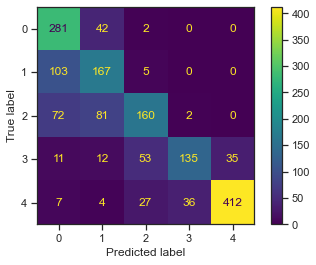

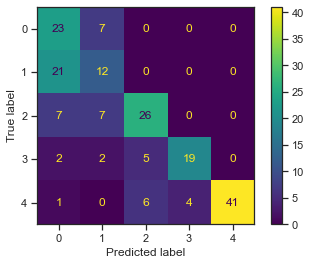

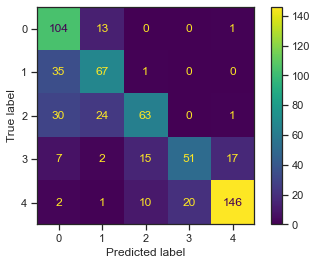

In [57]:
evaluation_parametrics("MultilayerCNN Neural Network", y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test)

In [58]:
# predict the first 4 images in the test set
prediction = cnn_model.predict(x_test[:4])
prediction

1/1 [==============================] - 0s 67ms/step


array([[1.2093512e-03, 2.1535305e-03, 4.9830042e-02, 2.8049842e-01,
        6.6630858e-01],
       [2.5545215e-02, 1.5321152e-01, 6.0977983e-01, 1.1710881e-01,
        9.4354570e-02],
       [1.3395632e-02, 1.1984149e-02, 5.6790486e-02, 3.3290878e-01,
        5.8492088e-01],
       [3.4380558e-01, 6.3050431e-01, 2.4709860e-02, 7.5133308e-04,
        2.2891739e-04]], dtype=float32)

In [59]:
y_test[:4]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

# ROC-AUC Analysis

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
#predict proba
y_proba = cnn_model.predict_on_batch(x_test)

In [61]:
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_proba,
    multi_class="ovr",
    average="micro",
)
micro_roc_auc_ovr

0.9295176027949478

In [62]:
auc = metrics.roc_auc_score(y_test, y_proba)
auc

0.9327429237112643

# Test the CNN Model

In [78]:
#load model
from keras.models import load_model
loaded_model=load_model("day5_embryo_cnn_model.h5")

In [79]:
classes = [1, 2, 3, 4, 5]
IMG_SIZE = 256

def embryo_predict(imgfilepath):
    
    img_array = cv2.imread(imgfilepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE) )
    # Normalizing the image
    image=new_array/255.0
    prediction = loaded_model.predict([image.reshape(-1, IMG_SIZE, IMG_SIZE, 3)])
    MaxPosition=np.argmax(prediction)  
    prediction_label=classes[MaxPosition]
    
    if prediction_label == 1:
        return "This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."
    elif prediction_label == 2:
        return "This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."
    elif prediction_label == 3:
        return "This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."
    elif prediction_label == 4:
        return "This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."
    elif prediction_label == 5:
        return "This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [80]:
embryo_predict('embryo-dataset/ed4/alldata/1/0.png')

1/1 [==============================] - 0s 129ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [81]:
embryo_predict('embryo-dataset/ed4/alldata/2/40.png')

1/1 [==============================] - 0s 42ms/step


"This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."

In [82]:
embryo_predict('embryo-dataset/ed4/alldata/3/126.png')

1/1 [==============================] - 0s 34ms/step


"This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."

In [83]:
embryo_predict('embryo-dataset/ed4/alldata/4/300.png')

1/1 [==============================] - 0s 40ms/step


"This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."

In [84]:
embryo_predict('embryo-dataset/ed4/alldata/5/700.png')

1/1 [==============================] - 0s 38ms/step


"This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [88]:
embryo_predict('test-model/google-degenerate.jpg')

1/1 [==============================] - 0s 46ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [89]:
embryo_predict('test-model/1-391.png')

1/1 [==============================] - 0s 40ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [90]:
embryo_predict('test-model/5-400.png')

1/1 [==============================] - 0s 48ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."